## API로 이미지 불러와서 크롭

### 라이브러리 import

In [ ]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [ ]:
# Azure Custom Vision API 정보 (사용자가 직접 입력)



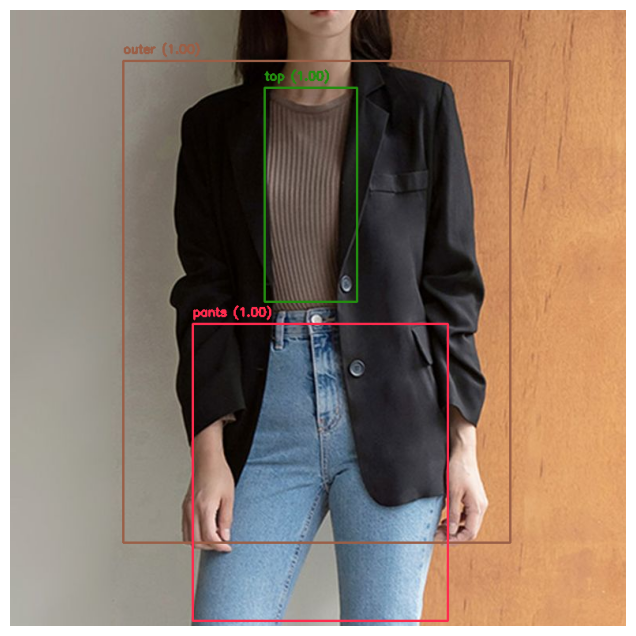

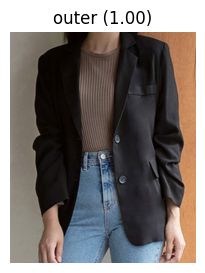

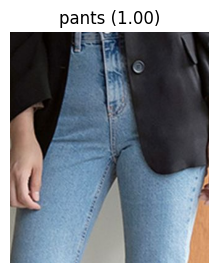

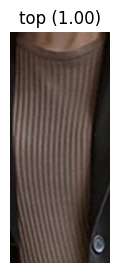

Tag: outer, Probability: 1.00, Image Shape: (610, 490, 3)
Tag: pants, Probability: 1.00, Image Shape: (376, 323, 3)
Tag: top, Probability: 1.00, Image Shape: (271, 117, 3)


In [ ]:
## Custom Vision 결과 확인
# 임계값 설정
THRESHOLD = 0.7  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": "51U32IRMi4rdmNqwvaX4IFoKpHS6gJTReP4YtA1Riwz5HwMbt1bMJQQJ99BBACHYHv6XJ3w3AAAIACOGpfOe",
        "Content-Type": "application/octet-stream"
    }
    url = f"{"https://chillchill-prediction.cognitiveservices.azure.com"}/customvision/v3.0/Prediction/{"9dcf7743-0e90-409f-beeb-35da8ae023aa"}/detect/iterations/{"Iteration6"}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 카테고리별 색상 선택
        color = category_colors[tag_name]

        # 바운딩 박스 및 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = "data/musinsa_images_outer/O10.jpg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)






## 필요한 부분만 가져오기
def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

        # 새 창에 개별 이미지 출력
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.title(f"{tag_name} ({probability:.2f})")
        plt.axis("off")
        plt.show()

    return cropped_images  # 크롭된 이미지 리스트 반환

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")



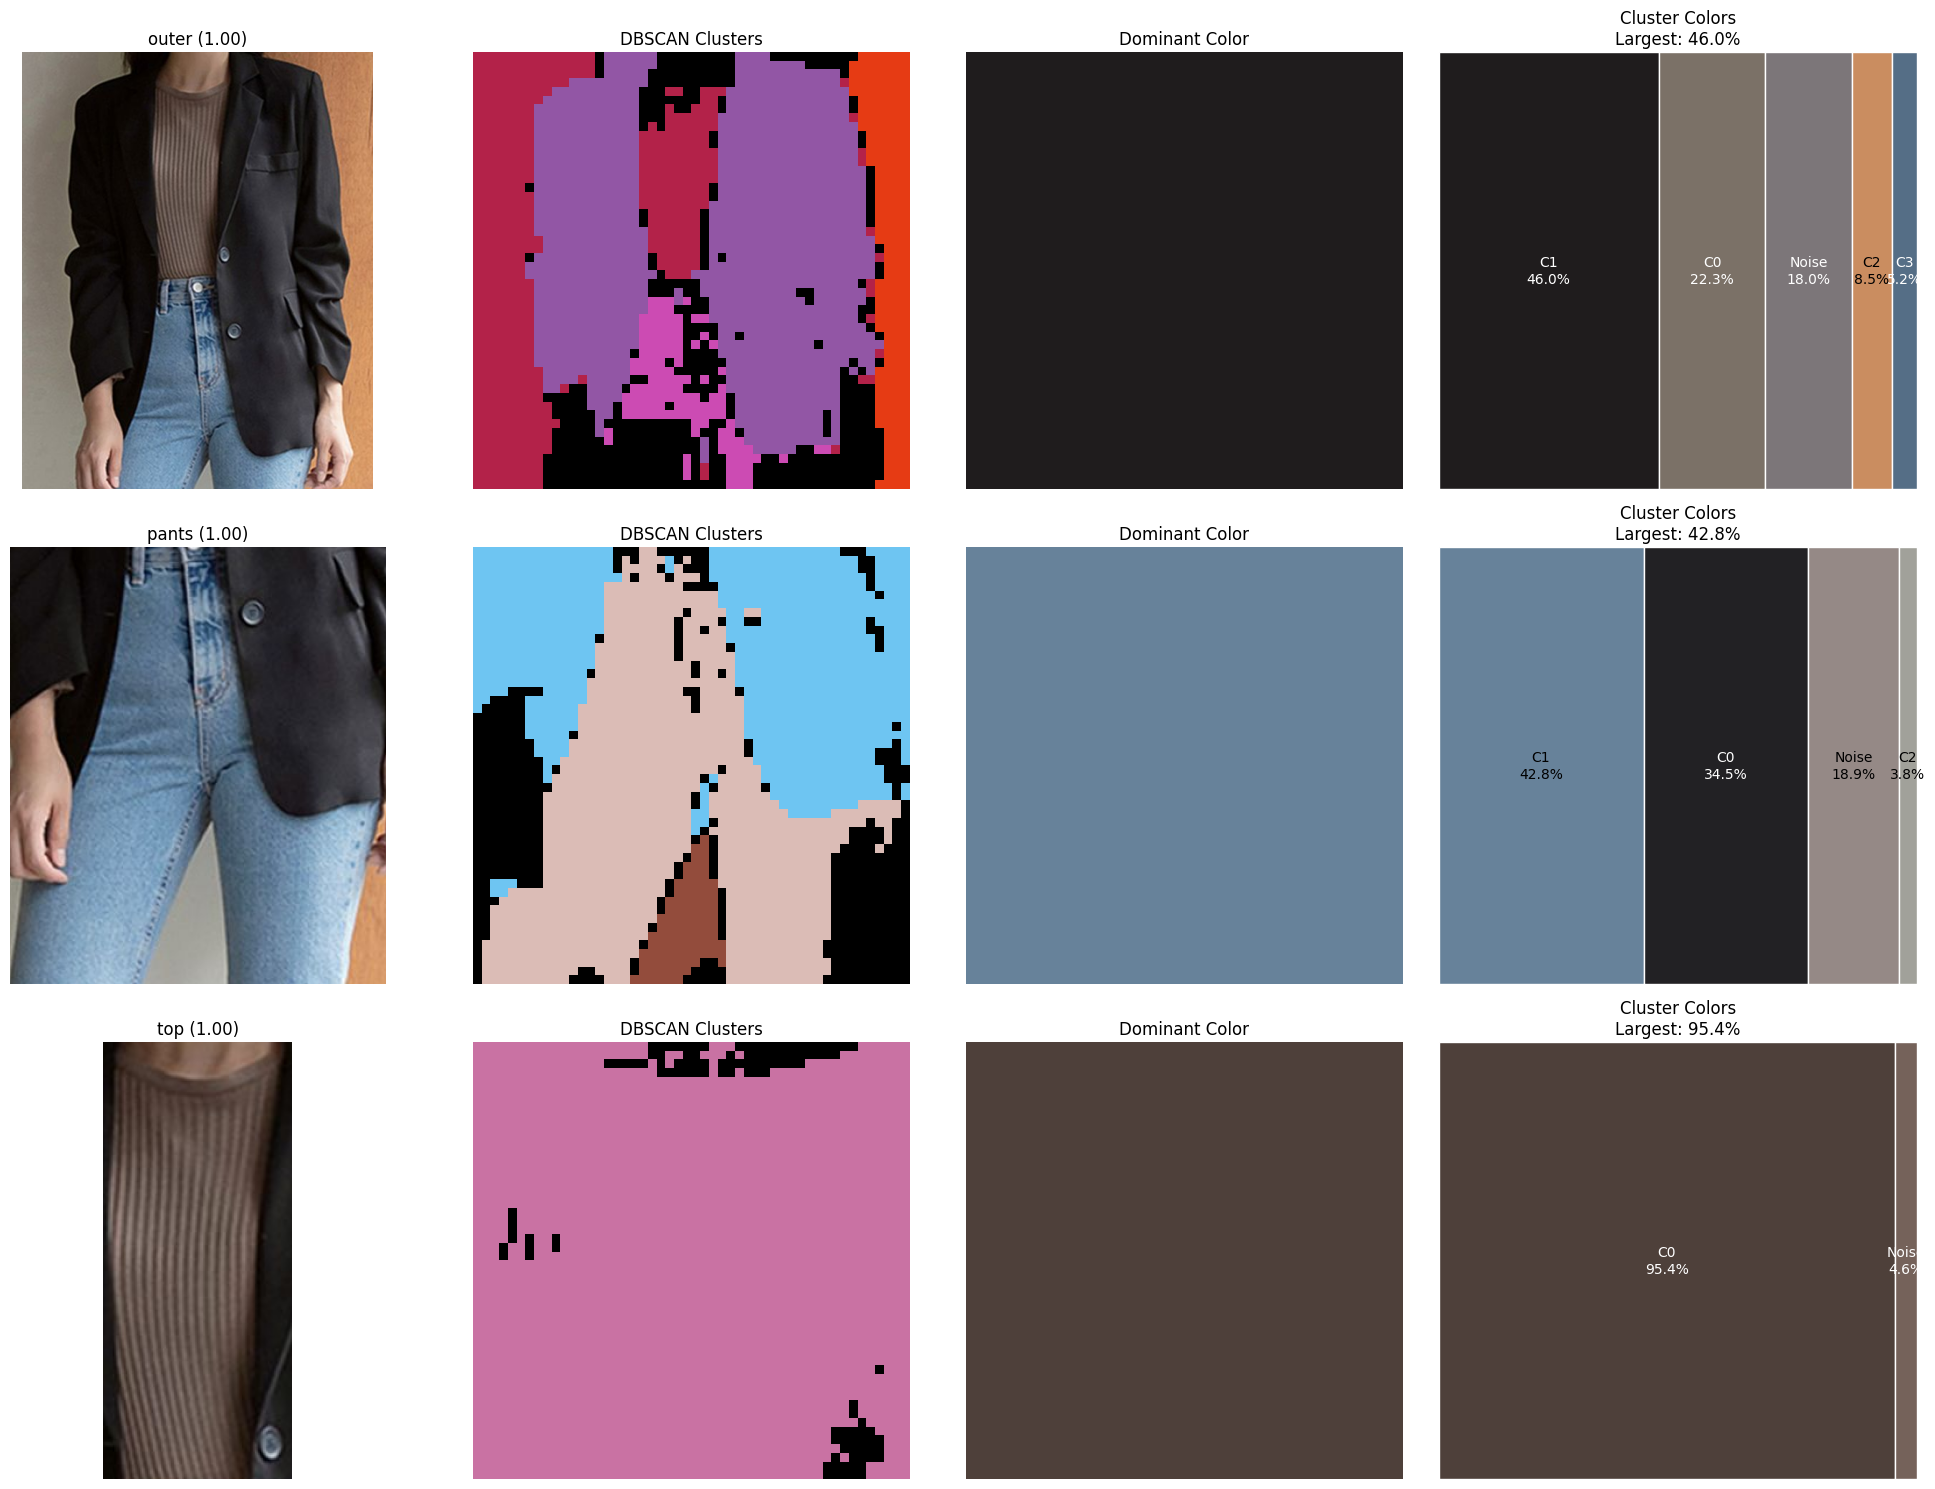

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def plot_cluster_color_bar(ax, sorted_clusters, total_pixels):
    """
    각 클러스터의 평균 색상과 픽셀 비율을 바탕으로, 
    효과적인 수평 색상 바를 그립니다.
    
    Args:
        ax (matplotlib.axes): 색상 바를 그릴 축.
        sorted_clusters (list): (label, (mean_color, count)) 튜플 리스트 (픽셀 수 기준 내림차순 정렬됨).
        total_pixels (int): 전체 픽셀 수.
    """
    left = 0.0
    for label, (mean_color, count) in sorted_clusters:
        proportion = count / total_pixels
        # 색상은 [0,1] 범위로 정규화
        color = np.array(mean_color) / 255.0
        rect = plt.Rectangle((left, 0), proportion, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        # 텍스트 색상: 배경이 밝으면 검은색, 어두우면 흰색
        text_color = 'black' if np.mean(color) > 0.5 else 'white'
        label_text = "Noise" if label == -1 else f"C{label}"
        ax.text(left + proportion/2, 0.5, f"{label_text}\n{proportion*100:.1f}%", 
                ha='center', va='center', fontsize=10, color=text_color)
        left += proportion
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

def show_all_cropped_visualizations_without_color_distribution(cropped_objects, eps=10, min_samples=50):
    """
    각 크롭 이미지마다 원본 이미지, DBSCAN 클러스터링 결과, 대표 색상, 
    그리고 DBSCAN 클러스터 색상 바(개선된 버전)를 한 행에 시각화합니다.
    
    Args:
        cropped_objects (list of tuples): (tag, probability, cropped_image) 튜플 리스트.
        eps (int): DBSCAN의 eps 값.
        min_samples (int): DBSCAN의 min_samples 값.
    """
    n = len(cropped_objects)
    if n == 0:
        print("표시할 크롭 이미지가 없습니다.")
        return

    # 각 크롭 이미지마다 4개의 서브플롯 (열: 4)
    fig, axes = plt.subplots(n, 4, figsize=(20, 5 * n))
    if n == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, (tag, prob, img) in enumerate(cropped_objects):
        # 1. 원본 크롭 이미지
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{tag} ({prob:.2f})")
        axes[i, 0].axis("off")
        
        # DBSCAN 분석을 위해 50x50으로 축소
        small_img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
        pixels = small_img.reshape((-1, 3))
        
        # 2. DBSCAN 클러스터링 결과
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pixels)
        unique_labels = np.unique(labels)
        cluster_colors = {}
        for label in unique_labels:
            if label == -1:
                cluster_colors[label] = (0, 0, 0)  # 노이즈는 검은색
            else:
                cluster_colors[label] = np.random.randint(0, 255, size=3)
        colored_pixels = np.array([cluster_colors[label] for label in labels])
        cluster_image = colored_pixels.reshape(small_img.shape)
        axes[i, 1].imshow(cluster_image)
        axes[i, 1].set_title("DBSCAN Clusters")
        axes[i, 1].axis("off")
        
        # 3. 대표 색상 (Dominant Color)
        valid_labels = labels[labels != -1]
        if len(valid_labels) > 0:
            unique_valid, counts = np.unique(valid_labels, return_counts=True)
            dominant_label = unique_valid[np.argmax(counts)]
        else:
            dominant_label = -1
        dominant_pixels = pixels[labels == dominant_label]
        if len(dominant_pixels) > 0:
            dominant_color = np.mean(dominant_pixels, axis=0)
        else:
            dominant_color = np.mean(pixels, axis=0)
        dominant_color = dominant_color.astype(int)
        dominant_patch = np.full((50, 50, 3), dominant_color, dtype=np.uint8)
        axes[i, 2].imshow(dominant_patch)
        axes[i, 2].set_title("Dominant Color")
        axes[i, 2].axis("off")
        
        # 4. 개선된 DBSCAN 클러스터 색상 바
        total_pixels = len(pixels)
        cluster_info = {}
        for label in unique_labels:
            cluster_pixels = pixels[labels == label]
            mean_color = np.mean(cluster_pixels, axis=0).astype(int)
            count = len(cluster_pixels)
            cluster_info[label] = (mean_color, count)
        sorted_clusters = sorted(cluster_info.items(), key=lambda x: x[1][1], reverse=True)
        plot_cluster_color_bar(axes[i, 3], sorted_clusters, total_pixels)
        largest_percentage = (sorted_clusters[0][1][1] / total_pixels) * 100
        axes[i, 3].set_title(f"Cluster Colors\nLargest: {largest_percentage:.1f}%")
    
    plt.tight_layout()
    plt.show()

# 사용 예시:
# cropped_objects는 (tag, probability, cropped_image) 튜플 리스트입니다.
show_all_cropped_visualizations_without_color_distribution(cropped_objects, eps=10, min_samples=50)
